In [1]:
from synet.networks import random_network
from synet.process import DelayProcess, DiseaseProcess, MajorityProcess, PredatorProcess
from synet.utils import apply_process, apply_measures
from pathlib import Path
import numpy as np
import pickle

In [2]:
n_events = 5000
n_agents = 100
n_communities = [1, 2, 3 ,4]
n_networks = 300
process_dt = 250
measure_dt = 100
n_jobs = 32

In [3]:
base_dir = Path("data")
base_dir.mkdir(exist_ok=True)

In [4]:
%%time
np.random.seed(1928374)
all_seeds = np.random.randint(0, 817934861, size=len(n_communities))
all_netsets = {}
for i_net, cur_comm in enumerate(n_communities):
    np.random.seed(all_seeds[i_net])
    name = f"a{n_agents}_e{n_events}_c{cur_comm}"
    net_fp = Path(base_dir, f"net_{name}.pkl")
    if net_fp.is_file():
        with open(net_fp, "rb") as f:
            all_netsets[name] = pickle.load(f)
        continue
    networks = [random_network(n_agents=n_agents, n_events=n_events, n_community=cur_comm)
                for _ in range(n_networks)]
    all_netsets[name] = networks
    with open(net_fp, "wb") as f:
        pickle.dump(networks, f)

CPU times: user 19.3 ms, sys: 71.9 ms, total: 91.2 ms
Wall time: 91.1 ms


In [5]:
processes = {
    "delay": {"process": DelayProcess(), "n_sim": 1000, "n_jobs": n_jobs},
    "majority": {"process": MajorityProcess(), "n_sim": 200, "n_jobs": n_jobs},
    "disease": {"process": DiseaseProcess(), "n_sim": 500, "n_jobs": n_jobs},
    "predator": {"process": PredatorProcess(), "n_sim": 1000, "n_jobs": n_jobs},
}

In [6]:
%%time

all_process_results = {}
for name, networks in all_netsets.items():
    process_fp = Path(base_dir, f"proc_{name}.pkl")
    try:
        with open(process_fp, "rb") as f:
            all_process_results[name] = pickle.load(f)
        continue
    except BaseException:
        pass

    process_results = {}
    for name, process_args in processes.items():
        res = apply_process(networks, dt=process_dt, **process_args)
        process_results[name] = res

    with open(process_fp, "wb") as f:
        pickle.dump(process_results, f)
    process_results[name] = process_results


CPU times: user 8.97 ms, sys: 1.42 s, total: 1.43 s
Wall time: 1.43 s


In [7]:
%%time

all_measure_results = {}
for name, networks in all_netsets.items():
    measure_fp = Path(base_dir, f"meas_{name}.pkl")
    try:
        with open(measure_fp, "rb") as f:
            all_measure_results[name] = pickle.load(f)
        continue
    except BaseException:
        pass
    measure_results = apply_measures(networks, max_dt=measure_dt, n_jobs=n_jobs)
    with open(measure_fp, "wb") as f:
        pickle.dump(measure_results, f)
    all_measure_results[name] = measure_results

CPU times: user 9.65 ms, sys: 0 ns, total: 9.65 ms
Wall time: 9.35 ms


In [8]:
# Create a combined network
from collections import defaultdict
combined_process_results = defaultdict(lambda: [])
combined_measure_results = defaultdict(lambda: [])
for net_name, net_proc_data in all_process_results.items():
    net_meas_data = all_measure_results[net_name]
    for proc_name, proc_data in net_proc_data.items():
        combined_process_results[proc_name].extend(proc_data)
    for meas_name, meas_data in net_meas_data.items():
        combined_measure_results[meas_name].extend(meas_data)

all_process_results["combined"] = combined_process_results
all_measure_results["combined"] = combined_measure_results

In [9]:
# Add average results as a measure.

for net_name in all_process_results:
    process_results = all_process_results[net_name]
    n_network = len(process_results[list(process_results)[0]])
    avg_order = np.zeros(n_network)
    for proc_name, proc_res in process_results.items():
        avg_res = np.array([np.mean(r) for r in proc_res])
        order = np.argsort(avg_res)
        true_order = np.empty_like(order, dtype=int)
        true_order[order] = np.arange(len(order), dtype=int)

        avg_order += true_order/len(process_results)
    all_measure_results[net_name]["optimal"] = avg_order


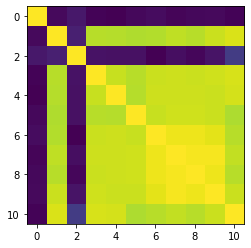

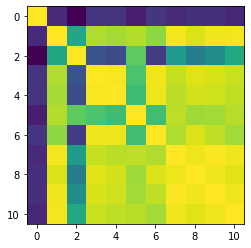

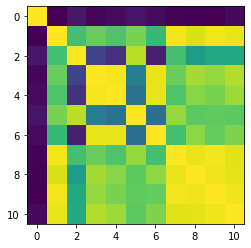

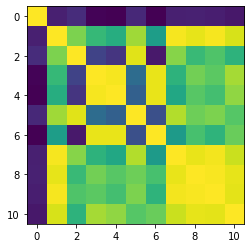

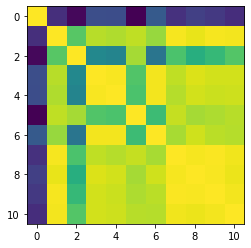

In [10]:
import pandas as pd
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from collections import defaultdict
def create_avg_results(process_results, measure_results):
    df = pd.DataFrame()
    n_network = len(process_results[list(process_results)[0]])
    df['net_id'] = np.arange(n_network)
    for name, res in process_results.items():
        cur_avg = np.array([np.mean(r) for r in res])
        df[name] = cur_avg
    for name, res in measure_results.items():
        df[name] = [np.mean(r) for r in res]
        

    return df


def add_best_results(df):
    df.drop("avg_order", errors="ignore")
    avg = np.zeros(len(df))
    for pr_name in list(df)[1:5]:
        order = np.argsort(df[pr_name].values)
        true_order = np.empty_like(order, dtype=int)
        true_order[order] = np.arange(len(order), dtype=int)

        avg += true_order

    new_order = avg/4
    df["avg_order"] = new_order
    return df


def create_cor_matrix(df):
    n_list = len(list(df))

    cor_matrix = np.zeros((n_list, n_list))
    for i_1, name_1 in enumerate(list(df)):
        for i_2, name_2 in enumerate(list(df)):
            cor_matrix[i_1, i_2] = spearmanr(df[name_1], df[name_2]).correlation
    return cor_matrix


def avg_measure_cor(cor_matrix, names):
    # measures
    res = {}
    for col in range(5, len(names)):
        avg = np.mean(cor_matrix[col, 1:5])
        res[names[col]] = avg
    return res

def avg_process_cor(cor_matrix, names):
    # processes
    res = {}
    for col in range(1, 5):
        avg = (np.sum(cor_matrix[col, 1:5])-1)/3
        res[names[col]] = avg
    return res

proc_avg_res = defaultdict(lambda: [])
meas_avg_res = defaultdict(lambda: [])
all_df = []
for net_name, proc_results in all_process_results.items():
    meas_results = all_measure_results[net_name]
    df = create_avg_results(proc_results, meas_results)
    cor_matrix = create_cor_matrix(df)
    proc_res = avg_process_cor(cor_matrix, list(df))
    meas_res = avg_measure_cor(cor_matrix, list(df))
    for proc_name, cur_res in proc_res.items():
        proc_avg_res[proc_name].append(cur_res)
    for meas_name, cur_res in meas_res.items():
        meas_avg_res[meas_name].append(cur_res)
    all_df.append(df)
    plt.imshow(cor_matrix)
    plt.show()

In [11]:
from pprint import pprint
pprint({k: np.mean(v) for k, v in proc_avg_res.items()})
pprint({k: np.mean(v) for k, v in meas_avg_res.items()})

{'delay': 0.7077097445575762,
 'disease': 0.6428018189677687,
 'majority': 0.27252163006947944,
 'predator': 0.6235278785581622}
{'agent': 0.6757766078409639,
 'mixing': 0.7717311032698229,
 'optimal': 0.8110212908317838,
 'overlap': 0.665927381726422,
 'paint': 0.7830552330521166,
 'path': 0.7696674322289105}


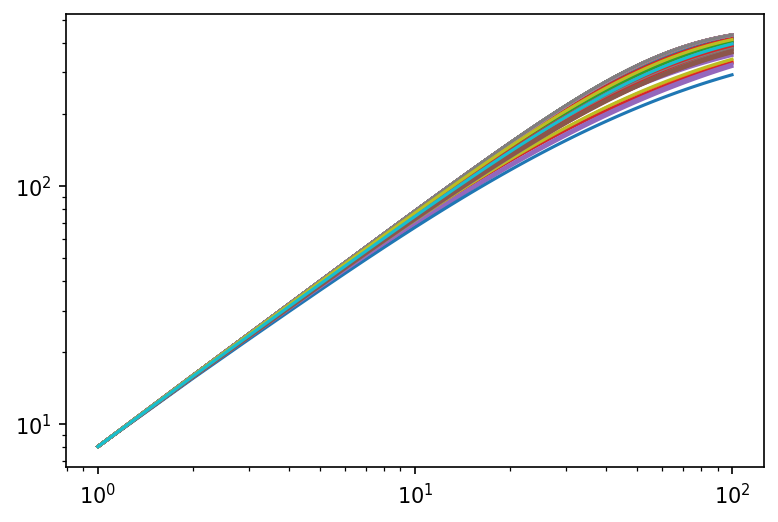

In [12]:
plt.figure(dpi=150)
plt.xscale('log')
plt.yscale('log')
for net_id, measure_results in enumerate(all_measure_results['combined']['mixing'][:100]):
    plt.plot(np.arange(len(measure_results))+1, measure_results)
plt.show()

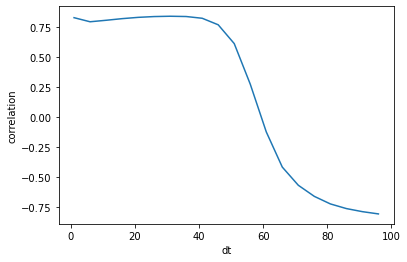

/home/qubix/.local/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


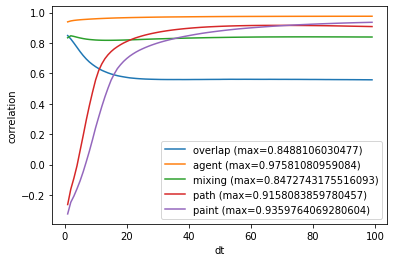

0.8417515498274651 -0.8096679164360531


In [13]:
from synet.visualization import plt_pvm_alpha, plot_pvm_dt
all_dt = np.arange(1, 100, 5)
cor = []
plt.xlabel("dt")
plt.ylabel("correlation")
for dt in all_dt:
    cor.append(plt_pvm_alpha(all_process_results["combined"]["predator"],
                             all_measure_results['combined']['mixing'], dt=dt))
plt.plot(all_dt, cor)
plt.show()
plot_pvm_dt(all_process_results["combined"]["predator"], all_measure_results['combined'])
print(np.max(cor), np.min(cor))

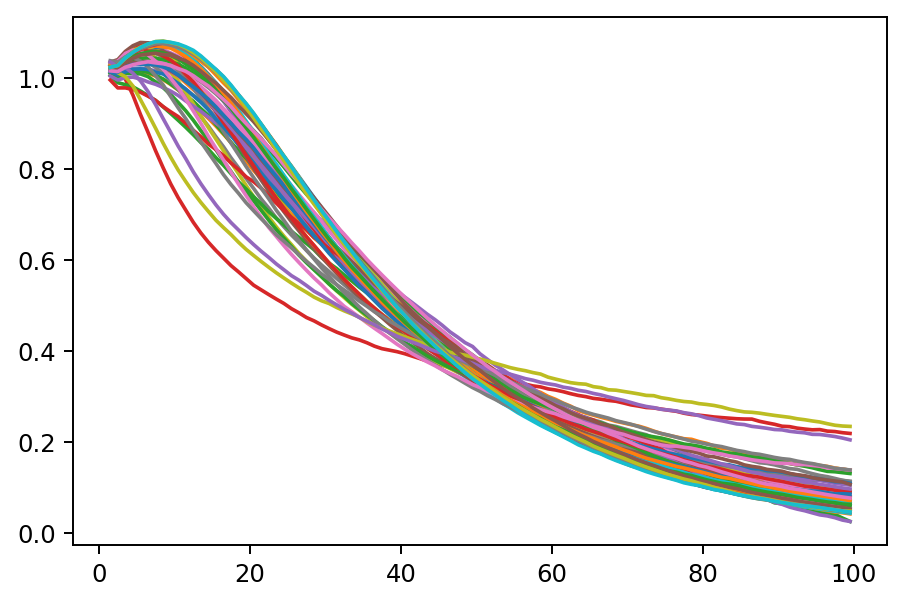

In [21]:
plt.figure(dpi=175)
n_measure = len(all_measure_results['combined']['mixing'][0])
t_start = np.arange(n_measure-1)+1
t_end = np.arange(n_measure-1)+2
t_avg = (t_start+t_end)/2
rand_idx = np.random.choice(1200, size=50, replace=False)
for measure_results in np.array(all_measure_results['combined']['path'])[rand_idx]:
    alpha_eff = np.log(measure_results[0:-1]/measure_results[1:])/np.log(t_start/t_end)
    plt.plot(t_avg, alpha_eff)
plt.show()

In [23]:
all_measure_results['combined']['path'][0]

array([  8.04554728,  16.35123954,  24.80656495,  33.47835905,
        42.36937739,  51.45207735,  60.7011295 ,  70.07718401,
        79.54835976,  89.07558054,  98.64531786, 108.2003778 ,
       117.72295356, 127.1725114 , 136.50830851, 145.70012312,
       154.74255578, 163.60000496, 172.26998899, 180.73187623,
       188.97003052, 196.96209583, 204.71029402, 212.20392117,
       219.44721422, 226.42530422, 233.15402432, 239.63277569,
       245.83859608, 251.79716512, 257.50279773, 262.96886492,
       268.20425518, 273.2139204 , 277.99319731, 282.55394918,
       286.89933933, 291.05489096, 295.0130546 , 298.77624131,
       302.36983397, 305.78394201, 309.02696594, 312.11224407,
       315.05315954, 317.84636052, 320.50256245, 323.02597499,
       325.42230118, 327.69568325, 329.85306454, 331.90178632,
       333.84906592, 335.69342446, 337.44094352, 339.09511422,
       340.66667865, 342.159592  , 343.57928563, 344.92520599,
       346.19982447, 347.40631896, 348.5536722 , 349.64

In [15]:
please_stop

NameError: name 'please_stop' is not defined

In [ ]:
%%time
from synet.bootstrap import create_process_bootstrap, create_xcor_boot_matrix, avg_correlations


results = {}
def add_results(results, new_result):
    if len(results) == 0:
        return new_result
    for meas_name in results:
        for bound_name in results[meas_name]:
            results[meas_name][bound_name].extend(new_result[meas_name][bound_name])
    return results

for netset_name, process_results in all_process_results.items():
    boot_results = create_process_bootstrap(process_results)
    xcor_matrix, cor_names = create_xcor_boot_matrix(boot_results, all_measure_results[netset_name])
    plt.plot(xcor_matrix[0, 0, :])
    new_result = avg_correlations(xcor_matrix, cor_names[1])
    results = add_results(results, new_result)
plt.show()

In [ ]:
plt.figure(dpi=150)
#xarr = 1+np.arange(len(all_process_results))
xarr = list(all_process_results)
for meas_name, res in results.items():
    yarr = np.array(res['median'])
    # yerr = np.abs(np.vstack((res['lower'], res['upper'])) - yarr)
    yerr = res["sem"]
    print(meas_name, yarr,np.mean(yarr-np.array(meas_avg_res[meas_name])))
    plt.errorbar(x=xarr, y=yarr, yerr=yerr, label=meas_name)
plt.legend()
plt.show()